In [1]:
# importing libraries:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import squarify  # treemap 
import seaborn as sns
import plotly.express as px
import datetime as dt
import warnings
warnings.filterwarnings("ignore")
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from yellowbrick.cluster import KElbowVisualizer

In [2]:
# Read csv file
df = pd.read_csv('retail.csv')

In [3]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [5]:
df.shape

(541909, 8)

In [6]:
# Null values 
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [7]:
# duplicates check
df.duplicated().value_counts()

False    536641
True       5268
dtype: int64

In [8]:
# Dropping duplicates
df.drop_duplicates(inplace=True)

In [9]:
df.duplicated().value_counts()

False    536641
dtype: int64

In [10]:
# Drop rows with null values
df.dropna(inplace=True)

In [11]:
df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [12]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,401604.000000,401604.000000,401604.000000
mean,12.183273,3.474064,15281.160818
std,250.283037,69.764035,1714.006089
min,-80995.000000,0.000000,12346.000000
25%,2.000000,1.250000,13939.000000
50%,5.000000,1.950000,15145.000000
75%,12.000000,3.750000,16784.000000
max,80995.000000,38970.000000,18287.000000


In [13]:
#Checking the data types of each column
df.dtypes

InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object

In [14]:
#Checking unique values
df.nunique()

InvoiceNo      22190
StockCode       3684
Description     3896
Quantity         436
InvoiceDate    20460
UnitPrice        620
CustomerID      4372
Country           37
dtype: int64

In [15]:
df['InvoiceNo'].nunique()

22190

#### Explolatory Data Analysis

In [16]:
# How many sales for each product?
df_product = df.groupby("Description").agg({"Quantity":"count"})
df_product.reset_index(inplace=True)
df_product

,Description,Quantity
0,4 PURPLE FLOCK DINNER CANDLES,37
1,50'S CHRISTMAS GIFT BAG LARGE,110
2,DOLLY GIRL BEAKER,137
3,I LOVE LONDON MINI BACKPACK,69
4,I LOVE LONDON MINI RUCKSACK,1
...,...,...
3891,ZINC T-LIGHT HOLDER STARS SMALL,241
3892,ZINC TOP 2 DOOR WOODEN SHELF,11
3893,ZINC WILLIE WINKIE CANDLE STICK,192
3894,ZINC WIRE KITCHEN ORGANISER,12


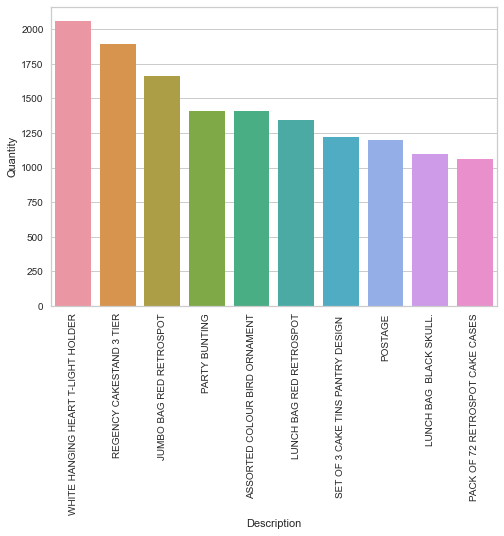

In [17]:
# Top 10 Products
top_pr= df_product.sort_values(by="Quantity",ascending=False).head(10)
sns.barplot(x="Description", y="Quantity", data=top_pr)
plt.xticks(rotation=90)
plt.show()

In [18]:
# number of products purchased in every transaction
df_no_of_products=df.groupby(["CustomerID","InvoiceNo"])["InvoiceDate"].count().reset_index()
nb_products_per_basket = df_no_of_products.rename(columns = {'InvoiceDate':'Number of products'})
nb_products_per_basket[:10].sort_values('CustomerID')

,CustomerID,InvoiceNo,Number of products
0,12346.0,541431,1
1,12346.0,C541433,1
2,12347.0,537626,31
3,12347.0,542237,29
4,12347.0,549222,24
5,12347.0,556201,18
6,12347.0,562032,22
7,12347.0,573511,47
8,12347.0,581180,11
9,12348.0,539318,17


It is worth noticing the existence of entries with the prefix C for the InvoiceNo variable: this indicates transactions that have been canceled

In [19]:
# count the number of transactions corresponding to canceled orders
nb_products_per_basket['order_canceled'] = nb_products_per_basket['InvoiceNo'].apply(lambda x:int('C' in x))
display(nb_products_per_basket[:5])
#______________________________________________________________________________________________
n1 = nb_products_per_basket['order_canceled'].sum()
n2 = nb_products_per_basket.shape[0]
print('Number of orders canceled: {}/{} ({:.2f}%) '.format(n1, n2, n1/n2*100))

,CustomerID,InvoiceNo,Number of products,order_canceled
0,12346.0,541431,1,0
1,12346.0,C541433,1,1
2,12347.0,537626,31,0
3,12347.0,542237,29,0
4,12347.0,549222,24,0


Number of orders canceled: 3654/22190 (16.47%) 


In [20]:
display(df.sort_values('CustomerID')[:5])

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,1/18/2011 10:01,1.04,12346.0,United Kingdom
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,1/18/2011 10:17,1.04,12346.0,United Kingdom
286623,562032,22375,AIRLINE BAG VINTAGE JET SET BROWN,4,8/2/2011 8:48,4.25,12347.0,Iceland
72260,542237,84991,60 TEATIME FAIRY CAKE CASES,24,1/26/2011 14:30,0.55,12347.0,Iceland
14943,537626,22772,PINK DRAWER KNOB ACRYLIC EDWARDIAN,12,12/7/2010 14:57,1.25,12347.0,Iceland


when an order is canceled, we have another transactions in the dataframe, mostly identical except for the Quantity and InvoiceDate variables. 
Is this true for all the entries? To check this, locate the entries that indicate a negative quantity and check if there is systematically an order indicating the same quantity (but positive), with the same description (CustomerID, Description and UnitPrice):

In [21]:
df_check = df[df['Quantity'] < 0][['CustomerID','Quantity',
                                                   'StockCode','Description','UnitPrice']]
for index, col in  df_check.iterrows():
    if df[(df['CustomerID'] == col[0]) & (df['Quantity'] == -col[1]) 
                & (df['Description'] == col[2])].shape[0] == 0: 
        print(df_check.loc[index])
        print(15*'-'+'>'+' HYPOTHESIS NOT FULFILLED')
        break

CustomerID      14527.0
Quantity             -1
StockCode             D
Description    Discount
UnitPrice          27.5
Name: 141, dtype: object
---------------> HYPOTHESIS NOT FULFILLED


The initial hypothesis is not fulfilled because of the existence of a 'Discount' entry. Lets check again the hypothesis but this time discarding the 'Discount' entries:

In [22]:
df_check = df[(df['Quantity'] < 0) & (df['Description'] != 'Discount')][
                                 ['CustomerID','Quantity','StockCode',
                                  'Description','UnitPrice']]

for index, col in  df_check.iterrows():
    if df[(df['CustomerID'] == col[0]) & (df['Quantity'] == -col[1]) 
                & (df['Description'] == col[2])].shape[0] == 0: 
        print(index, df_check.loc[index])
        print(15*'-'+'>'+' HYPOTHESIS NOT FULFILLED')
        break

154 CustomerID                             15311.0
Quantity                                    -1
StockCode                               35004C
Description    SET OF 3 COLOURED  FLYING DUCKS
UnitPrice                                 4.65
Name: 154, dtype: object
---------------> HYPOTHESIS NOT FULFILLED


we find that the initial hypothesis is not verified. Hence, cancellations do not necessarily correspond to orders that would have been made beforehand.
Lets filter out the cancel orders 

In [23]:
#Filter out records with negative values
df = df[df['Quantity'] > 0]
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392732 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    392732 non-null  object 
 1   StockCode    392732 non-null  object 
 2   Description  392732 non-null  object 
 3   Quantity     392732 non-null  int64  
 4   InvoiceDate  392732 non-null  object 
 5   UnitPrice    392732 non-null  float64
 6   CustomerID   392732 non-null  float64
 7   Country      392732 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 27.0+ MB


In [25]:
# Add Revenue column
df['Revenue'] = df['UnitPrice'] * df['Quantity']
df.sort_values('CustomerID')[:5]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,1/18/2011 10:01,1.04,12346.0,United Kingdom,77183.6
72246,542237,84625A,PINK NEW BAROQUECANDLESTICK CANDLE,24,1/26/2011 14:30,0.85,12347.0,Iceland,20.4
14952,537626,22729,ALARM CLOCK BAKELIKE ORANGE,4,12/7/2010 14:57,3.75,12347.0,Iceland,15.0
14953,537626,22212,FOUR HOOK WHITE LOVEBIRDS,6,12/7/2010 14:57,2.10,12347.0,Iceland,12.6
14954,537626,85167B,BLACK GRAND BAROQUE PHOTO FRAME,30,12/7/2010 14:57,1.25,12347.0,Iceland,37.5


In [26]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34


In [27]:
# What is the number of users and products in our dataset
pd.DataFrame([{'products': len(df['StockCode'].value_counts()),    
               'transactions': len(df['InvoiceNo'].value_counts()),
               'customers': len(df['CustomerID'].value_counts()),  
              }], columns = ['products', 'transactions', 'customers'], index = ['quantity'])

,products,transactions,customers
quantity,3665,18536,4339


In [28]:
# Changing invoice date column data type
df['InvoiceDate']=pd.to_datetime(df["InvoiceDate"])

In [29]:
df['InvoiceDate'].info()

<class 'pandas.core.series.Series'>
Int64Index: 392732 entries, 0 to 541908
Series name: InvoiceDate
Non-Null Count   Dtype         
--------------   -----         
392732 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 6.0 MB


In [30]:
# Extracting year and month
df['InvoiceMonth'] = df['InvoiceDate'].dt.month
df['InvoiceYear'] = df['InvoiceDate'].dt.year

In [31]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue,InvoiceMonth,InvoiceYear
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,12,2010
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,12,2010
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,12,2010
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,12,2010
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,12,2010


#### Monthly Revenue

In [32]:
# years present in the dataset
df['InvoiceYear']. value_counts()

2011    367059
2010     25673
Name: InvoiceYear, dtype: int64

In [33]:
# Months present in 2010
y_2010 = df[df["InvoiceYear"]== 2010]
y_2010['InvoiceMonth'].unique()

array([12], dtype=int64)

In [34]:
# Months present in 2011
y_2011 = df[df["InvoiceYear"]== 2011]
y_2011['InvoiceMonth'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12], dtype=int64)

In [35]:
#Monthly Revenue 
df_revenue = df.groupby(["InvoiceMonth", "InvoiceYear"])["Revenue"].sum().reset_index()
df_revenue

,InvoiceMonth,InvoiceYear,Revenue
0,1,2011,568101.310
1,2,2011,446084.920
2,3,2011,594081.760
3,4,2011,468374.331
4,5,2011,677355.150
5,6,2011,660046.050
6,7,2011,598962.901
7,8,2011,644051.040
8,9,2011,950690.202
9,10,2011,1035642.450


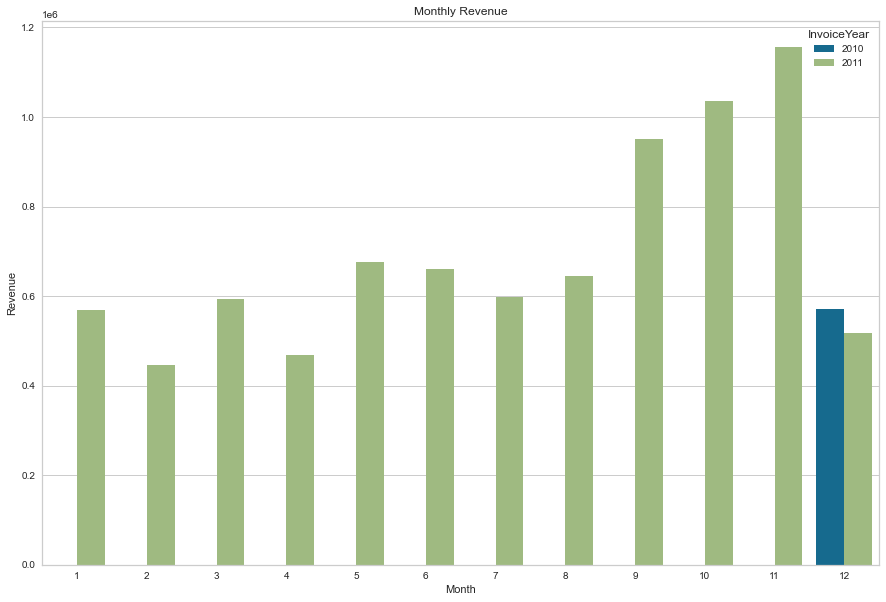

In [36]:
# Monthly Revenue plot
plt.figure(figsize=(15,10))
sns.barplot(x="InvoiceMonth", y="Revenue", hue="InvoiceYear", data=df_revenue)
plt.title("Monthly Revenue")
plt.xlabel("Month")
plt.ylabel("Revenue")
plt.show()

In [37]:
# December sales in 2011 are quite low, why?
df_december_2011 = df.query("InvoiceMonth==12 and InvoiceYear==2011")
df_december_2011['InvoiceDay'] = df_december_2011['InvoiceDate'].dt.day

In [38]:
df_december_2011['InvoiceDay'].value_counts()

5    3335
6    2503
8    2499
7    2135
1    2120
2    1939
4    1885
9     610
Name: InvoiceDay, dtype: int64

therefore the reason as to why revenue was low in December its because we do not have the complete dataset for the month. 

#### Monthly Items Sold

In [39]:
df_quantity=df.groupby(["InvoiceMonth", "InvoiceYear"])["Quantity"].sum().reset_index()
df_quantity

,InvoiceMonth,InvoiceYear,Quantity
0,1,2011,348522
1,2,2011,265043
2,3,2011,347623
3,4,2011,291369
4,5,2011,372948
5,6,2011,363014
6,7,2011,367372
7,8,2011,398190
8,9,2011,543654
9,10,2011,591551


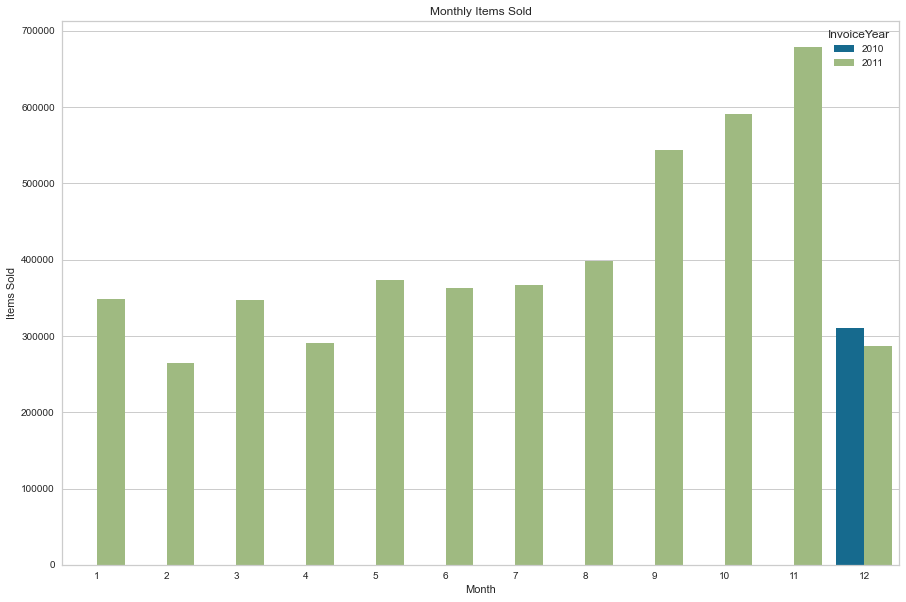

In [40]:
plt.figure(figsize=(15,10))
sns.barplot(x="InvoiceMonth", y="Quantity", hue="InvoiceYear",data=df_quantity)
plt.title("Monthly Items Sold")
plt.xlabel("Month")
plt.ylabel("Items Sold")
plt.show()

In [41]:
# Monthly Active Customers
df_active=df.groupby(["InvoiceMonth", "InvoiceYear"])["CustomerID"].nunique().reset_index()
df_active

,InvoiceMonth,InvoiceYear,CustomerID
0,1,2011,741
1,2,2011,758
2,3,2011,974
3,4,2011,856
4,5,2011,1056
5,6,2011,991
6,7,2011,949
7,8,2011,935
8,9,2011,1266
9,10,2011,1364


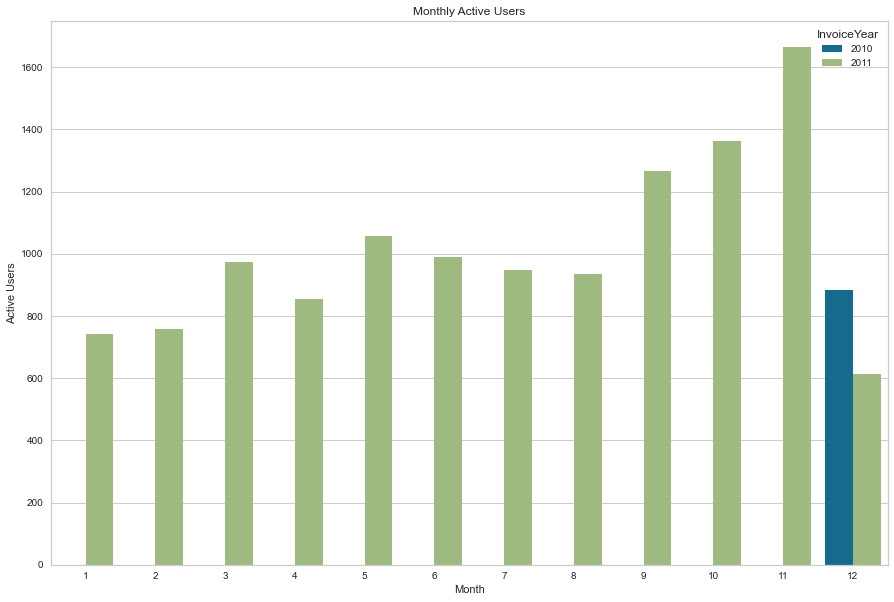

In [42]:
plt.figure(figsize=(15,10))
sns.barplot(x="InvoiceMonth", y="CustomerID", hue="InvoiceYear", data=df_active)
plt.title("Monthly Active Users")
plt.xlabel("Month")
plt.ylabel("Active Users")
plt.show()

In [43]:
df_active_2011 = df_active[df_active['InvoiceYear'] != 2010]
df_active_2011

,InvoiceMonth,InvoiceYear,CustomerID
0,1,2011,741
1,2,2011,758
2,3,2011,974
3,4,2011,856
4,5,2011,1056
5,6,2011,991
6,7,2011,949
7,8,2011,935
8,9,2011,1266
9,10,2011,1364


#### New vs Existing Users

In [44]:
df_first_purchase=df.groupby(["CustomerID"])["InvoiceDate"].min().reset_index()
df_first_purchase.columns=["CustomerID", "FirstPurchaseDate"]
df=pd.merge(df, df_first_purchase, on="CustomerID")
df["UserType"]="New"
df.loc[df["InvoiceDate"] > df["FirstPurchaseDate"], "UserType"]="Existing"
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue,InvoiceMonth,InvoiceYear,FirstPurchaseDate,UserType
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,12,2010,2010-12-01 08:26:00,New
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,12,2010,2010-12-01 08:26:00,New
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,12,2010,2010-12-01 08:26:00,New
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,12,2010,2010-12-01 08:26:00,New
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,12,2010,2010-12-01 08:26:00,New


In [45]:
# New vs Existing User Revenue Analysis
df_new_revenue=df.groupby(["InvoiceMonth", "InvoiceYear", "UserType"])["Revenue"].sum().reset_index()
df_new_revenue

,InvoiceMonth,InvoiceYear,UserType,Revenue
0,1,2011,Existing,297586.870
1,1,2011,New,270514.440
2,2,2011,Existing,300355.440
3,2,2011,New,145729.480
4,3,2011,Existing,410216.170
5,3,2011,New,183865.590
6,4,2011,Existing,356637.200
7,4,2011,New,111737.131
8,5,2011,Existing,565148.370
9,5,2011,New,112206.780


In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392732 entries, 0 to 392731
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   InvoiceNo          392732 non-null  object        
 1   StockCode          392732 non-null  object        
 2   Description        392732 non-null  object        
 3   Quantity           392732 non-null  int64         
 4   InvoiceDate        392732 non-null  datetime64[ns]
 5   UnitPrice          392732 non-null  float64       
 6   CustomerID         392732 non-null  float64       
 7   Country            392732 non-null  object        
 8   Revenue            392732 non-null  float64       
 9   InvoiceMonth       392732 non-null  int64         
 10  InvoiceYear        392732 non-null  int64         
 11  FirstPurchaseDate  392732 non-null  datetime64[ns]
 12  UserType           392732 non-null  object        
dtypes: datetime64[ns](2), float64(3), int64(3), 

<Figure size 576x396 with 0 Axes>

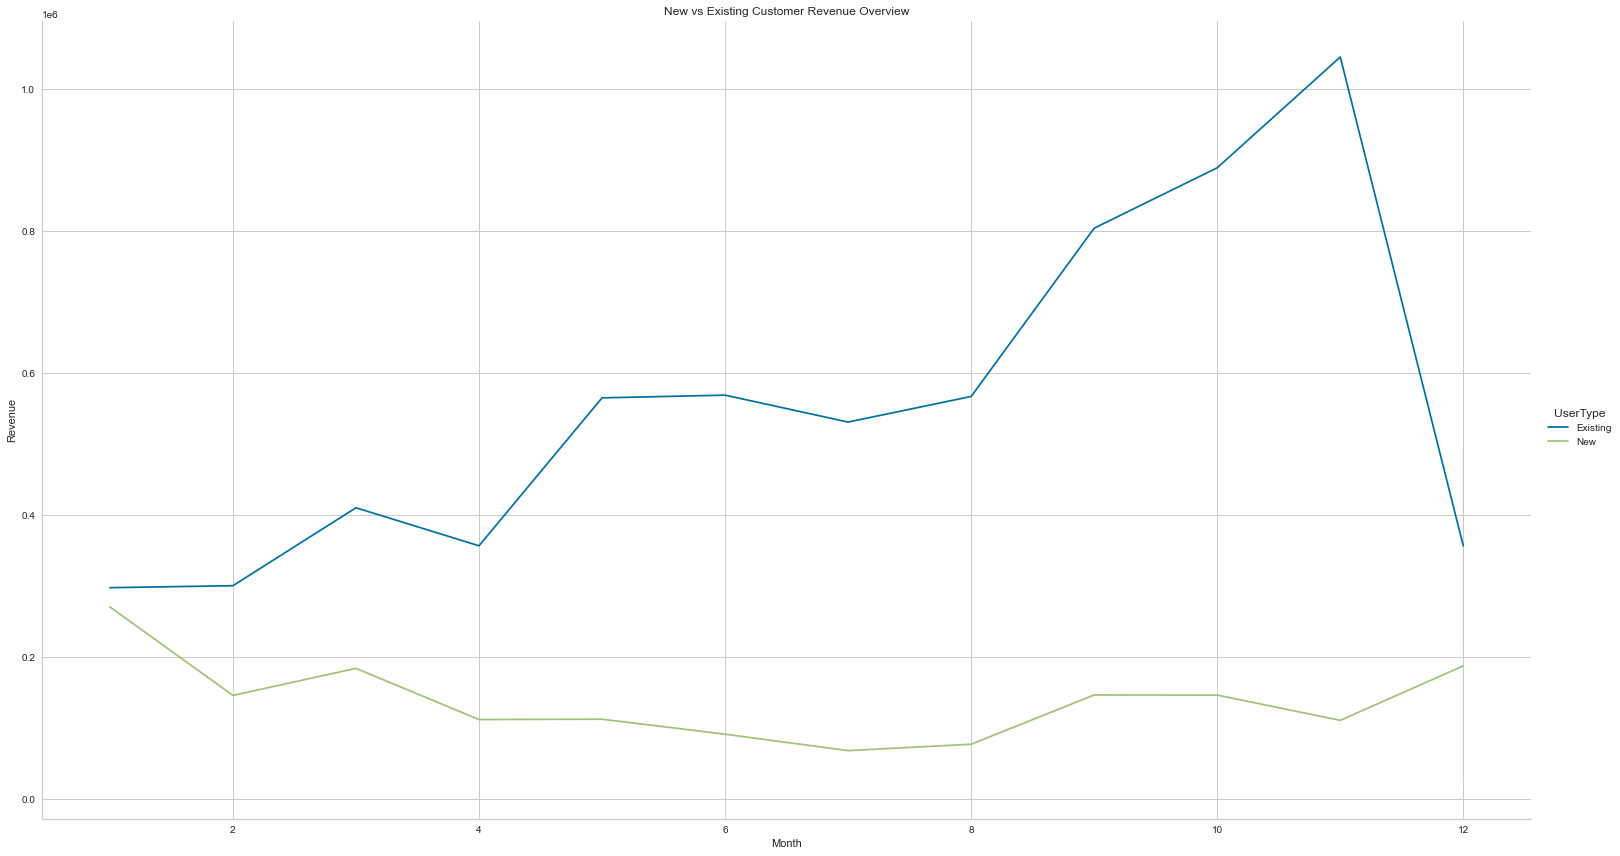

In [47]:
plt.figure()
sns.relplot(x="InvoiceMonth", y="Revenue", hue="UserType", data=df_new_revenue, kind="line", height=12, aspect=18/10)
plt.title("New vs Existing Customer Revenue Overview")
plt.xlabel("Month")
plt.ylabel("Revenue")
plt.show()

Text(0.5, 1.0, 'New vs Existing Customer Revenue Overview')

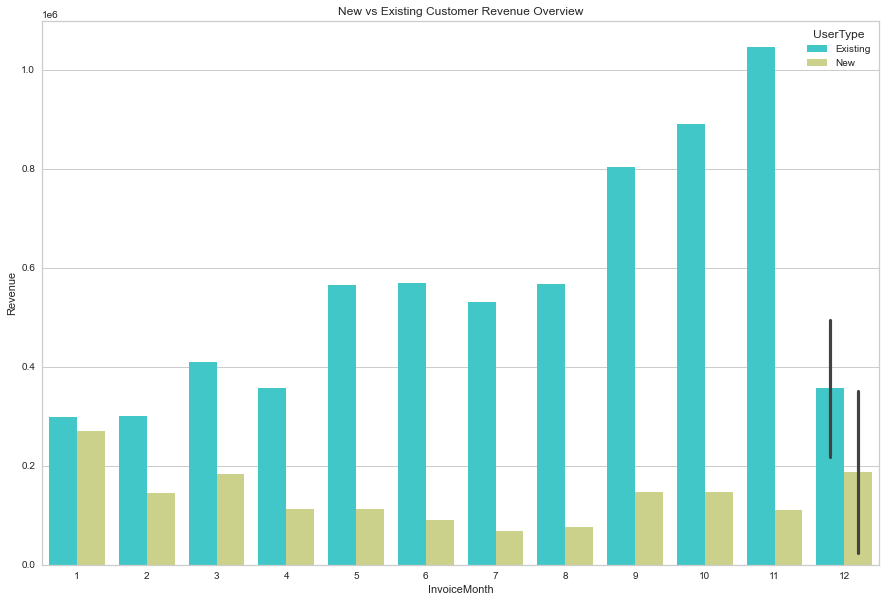

In [48]:
plt.figure(figsize=(15,10))
sns.barplot(x='InvoiceMonth',y='Revenue',data=df_new_revenue, palette='rainbow', hue='UserType')
plt.title("New vs Existing Customer Revenue Overview")

#### Frequency of orders

In [49]:
df_user=pd.DataFrame(df["CustomerID"].unique())
df_user.columns=["CustomerID"]
df_user

,CustomerID
0,17850.0
1,13047.0
2,12583.0
3,13748.0
4,15100.0
...,...
4334,13436.0
4335,15520.0
4336,13298.0
4337,14569.0


In [50]:
df_frequency=df.groupby(["CustomerID"])["InvoiceDate"].count().reset_index()
df_frequency.columns=["CustomerID", "Frequency"]
df_frequency=pd.merge(df_user, df_frequency, on="CustomerID")
df_frequency.head()

,CustomerID,Frequency
0,17850.0,297
1,13047.0,172
2,12583.0,247
3,13748.0,28
4,15100.0,3


<Figure size 1080x720 with 0 Axes>

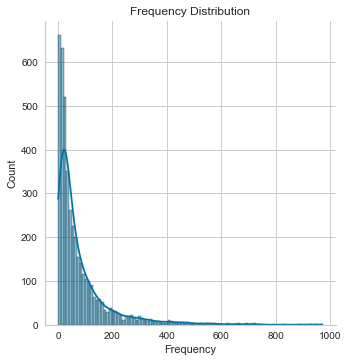

In [51]:
plt.figure(figsize=(15,10))
sns.displot(df_frequency.query("Frequency<1000")["Frequency"], kde=True)
plt.title("Frequency Distribution")
plt.xlabel("Frequency")
plt.ylabel("Count")
plt.show()

In [52]:
# Revenue by country
rev_by_country = df.groupby('Country').Revenue.sum().reset_index()
rev_by_country.columns=['Country', 'Revenue']
rev_by_country.sort_values(by = ['Revenue'], ascending=False)

,Country,Revenue
35,United Kingdom,7285024.644
23,Netherlands,285446.340
10,EIRE,265262.460
14,Germany,228678.400
13,France,208934.310
0,Australia,138453.810
30,Spain,61558.560
32,Switzerland,56443.950
3,Belgium,41196.340
31,Sweden,38367.830


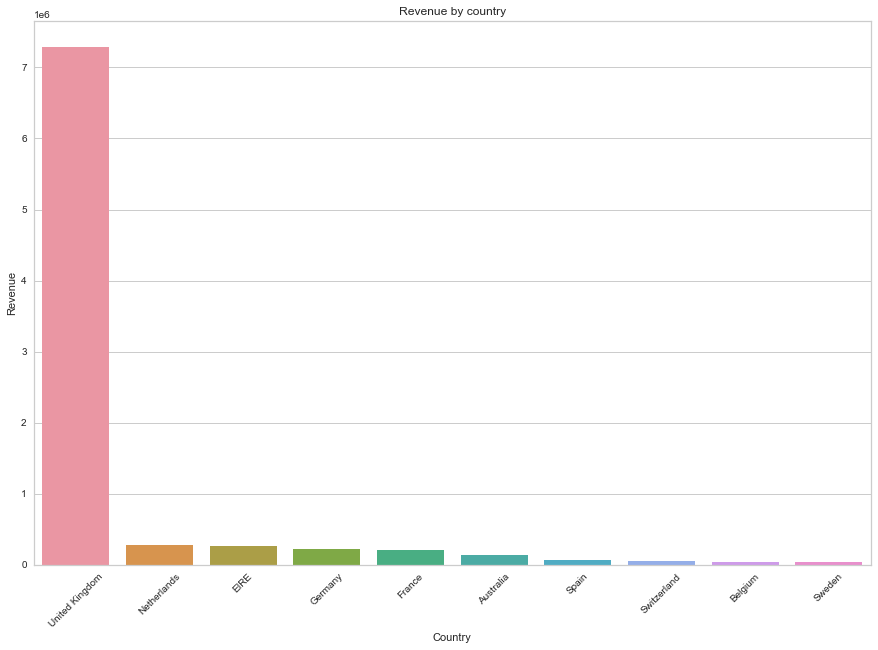

In [53]:
# Top 10 countries in revenue 
top_country= rev_by_country.sort_values(by="Revenue",ascending=False).head(10)
plt.figure(figsize=(15,10))
sns.barplot(x="Country", y="Revenue", data=top_country)
plt.title("Revenue by country")
plt.xlabel("Country")
plt.ylabel("Revenue")
plt.xticks(rotation=45)
plt.show()

In [54]:
#transactions made by each customer type 
df_temp=df.groupby(["UserType", "InvoiceMonth","InvoiceYear"])["InvoiceNo"].nunique().reset_index()
df_transaction = df_temp.rename(columns = {'InvoiceNo':'Number of transactions'})
df_transaction[:10].sort_values('UserType')

,UserType,InvoiceMonth,InvoiceYear,Number of transactions
0,Existing,1,2011,572
1,Existing,2,2011,621
2,Existing,3,2011,870
3,Existing,4,2011,849
4,Existing,5,2011,1271
5,Existing,6,2011,1150
6,Existing,7,2011,1142
7,Existing,8,2011,1113
8,Existing,9,2011,1455
9,Existing,10,2011,1571


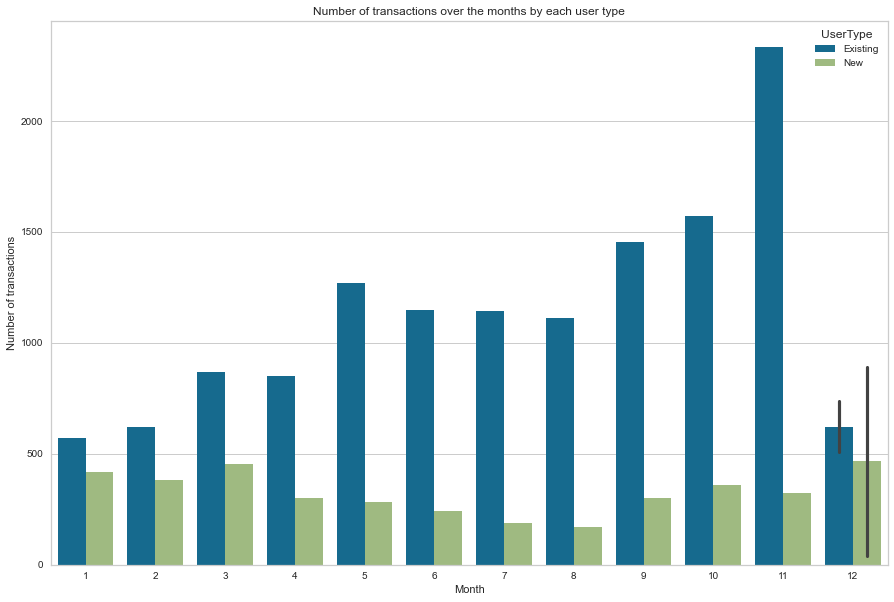

In [55]:
#which month received the highest number of trasactions
trans= df_transaction.sort_values(by="Number of transactions",ascending=False)
plt.figure(figsize=(15,10))
sns.barplot(x="InvoiceMonth", y="Number of transactions", hue = "UserType", data=trans)
plt.title("Number of transactions over the months by each user type")
plt.xlabel("Month")
plt.ylabel("Number of transactions")
plt.show()

In [56]:
df_temp=df.groupby(["UserType", "InvoiceMonth"])["CustomerID"].nunique().reset_index()
df_usertype = df_temp.rename(columns = {'CustomerID':'UserType count'})
df_usertype[:12].sort_values('UserType count')

,UserType,InvoiceMonth,UserType count
0,Existing,1,372
1,Existing,2,416
2,Existing,3,564
3,Existing,4,587
11,Existing,12,718
5,Existing,6,772
7,Existing,8,779
6,Existing,7,780
4,Existing,5,809
8,Existing,9,994


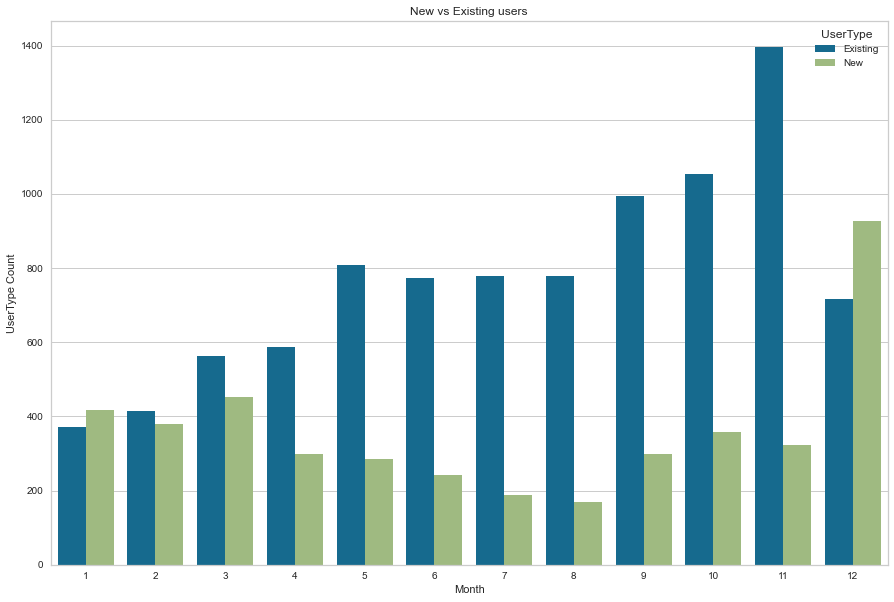

In [57]:
# What are the numbers? New vs Existing users. are we able to retain clients? 
user= df_usertype.sort_values(by="UserType count",ascending=False)
plt.figure(figsize=(15,10))
sns.barplot(x="InvoiceMonth", y="UserType count", hue = "UserType", data=user)
plt.title("New vs Existing users")
plt.xlabel("Month")
plt.ylabel("UserType Count")
plt.show()

#### RFM MODELLING

In [58]:
# Latest date
latest_date =df['InvoiceDate'].max()
latest_date

Timestamp('2011-12-09 12:50:00')

In [59]:
#Set Latest date 2011-12-10 as last invoice date was 2011-12-09. This is to calculate the number of days from recent purchase
Latest_Date = dt.datetime(2011,12,10)
Latest_Date

datetime.datetime(2011, 12, 10, 0, 0)

In [60]:
#Create RFM Modelling scores for each customer

#Recency = Latest Date - Last Invoice Data,
#Frequency = count of invoice no. of transaction(s),
#Monetary = Sum of Total Amount for each customer

# Generating RFM metrics
rfm = df.groupby("CustomerID").agg({"InvoiceDate": lambda InvoiceDate: (Latest_Date- InvoiceDate.max()).days,
                                    "InvoiceNo": lambda InvoiceNo: InvoiceNo.nunique(),
                                    "Revenue": lambda Revenue: Revenue.sum()})

rfm.columns = ["recency","frequency","monetary"]
rfm.describe().T

,count,mean,std,min,25%,50%,75%,max
recency,4339.0,92.041484,100.007757,0.0,17.000,50.00,141.500,373.00
frequency,4339.0,4.271952,7.705493,1.0,1.000,2.00,5.000,210.00
monetary,4339.0,2048.215924,8984.248352,0.0,306.455,668.56,1660.315,280206.02


In [61]:
# monetary, the min value of the total money paid can't be 0
# let's remove them from the data

rfm = rfm[rfm["monetary"] > 0]
rfm.describe().T

,count,mean,std,min,25%,50%,75%,max
recency,4338.0,92.059474,100.012264,0.00,17.0000,50.00,141.7500,373.00
frequency,4338.0,4.272706,7.706221,1.00,1.0000,2.00,5.0000,210.00
monetary,4338.0,2048.688081,8985.230220,3.75,306.4825,668.57,1660.5975,280206.02


In [62]:
rfm.reset_index().head()

,CustomerID,recency,frequency,monetary
0,12346.0,325,1,77183.60
1,12347.0,2,7,4310.00
2,12348.0,75,4,1797.24
3,12349.0,18,1,1757.55
4,12350.0,310,1,334.40


In [63]:
# recency_score
rfm["recency_score"] = pd.qcut(rfm['recency'], 5, labels=[5, 4, 3, 2, 1])
# frequency_score
rfm["frequency_score"] = pd.qcut(rfm["frequency"].rank(method="first"), 5, labels=[1, 2, 3, 4, 5])
# monetary_score
rfm["monetary_score"] = pd.qcut(rfm["monetary"], 5, labels=[1, 2, 3, 4, 5])

#  RFM Score
rfm["RFM_SCORE"] = (rfm["recency_score"].astype(str) + rfm["frequency_score"].astype(str))
rfm.head(10)

,recency,frequency,monetary,recency_score,frequency_score,monetary_score,RFM_SCORE
CustomerID,,,,,,,
12346.0,325,1,77183.60,1,1,5,11
12347.0,2,7,4310.00,5,5,5,55
12348.0,75,4,1797.24,2,4,4,24
12349.0,18,1,1757.55,4,1,4,41
12350.0,310,1,334.40,1,1,2,11
12352.0,36,8,2506.04,3,5,5,35
12353.0,204,1,89.00,1,1,1,11
12354.0,232,1,1079.40,1,1,4,11
12355.0,214,1,459.40,1,1,2,11


In [64]:
# Segmenting Customers Based on RFM Scores
seg_map = {
    r'[1-2][1-2]': 'hibernating',
    r'[1-2][3-4]': 'at_Risk',
    r'[1-2]5': 'cant_loose',
    r'3[1-2]': 'about_to_sleep',
    r'33': 'need_attention',
    r'[3-4][4-5]': 'loyal_customers',
    r'41': 'promising',
    r'51': 'new_customers',
    r'[4-5][2-3]': 'potential_loyalists',
    r'5[4-5]': 'champions'
}
rfm['segment'] = rfm['RFM_SCORE'].replace(seg_map, regex=True)
rfm.head(10)

,recency,frequency,monetary,recency_score,frequency_score,monetary_score,RFM_SCORE,segment
CustomerID,,,,,,,,
12346.0,325,1,77183.60,1,1,5,11,hibernating
12347.0,2,7,4310.00,5,5,5,55,champions
12348.0,75,4,1797.24,2,4,4,24,at_Risk
12349.0,18,1,1757.55,4,1,4,41,promising
12350.0,310,1,334.40,1,1,2,11,hibernating
12352.0,36,8,2506.04,3,5,5,35,loyal_customers
12353.0,204,1,89.00,1,1,1,11,hibernating
12354.0,232,1,1079.40,1,1,4,11,hibernating
12355.0,214,1,459.40,1,1,2,11,hibernating


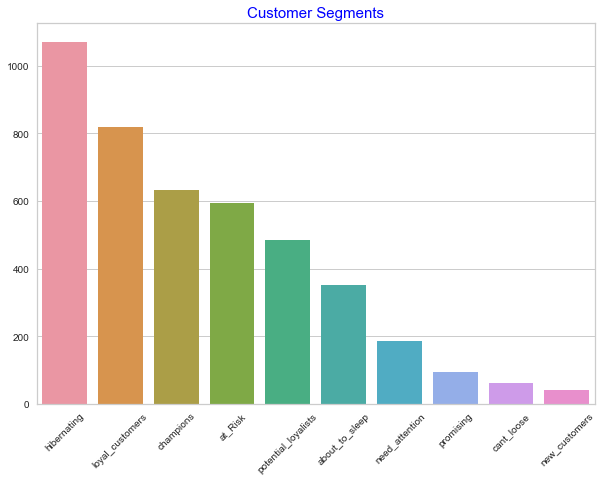

In [65]:
sgm= rfm["segment"].value_counts()
plt.figure(figsize=(10,7))
sns.barplot(x=sgm.index,y=sgm.values)
plt.xticks(rotation=45)
plt.title('Customer Segments',color = 'blue',fontsize=15)
plt.show()

In [66]:
# Treemap Visualization
df_treemap = rfm.groupby('segment').agg('count').reset_index()
df_treemap.head()

,segment,recency,frequency,monetary,recency_score,frequency_score,monetary_score,RFM_SCORE
0,about_to_sleep,352,352,352,352,352,352,352
1,at_Risk,593,593,593,593,593,593,593
2,cant_loose,63,63,63,63,63,63,63
3,champions,633,633,633,633,633,633,633
4,hibernating,1071,1071,1071,1071,1071,1071,1071


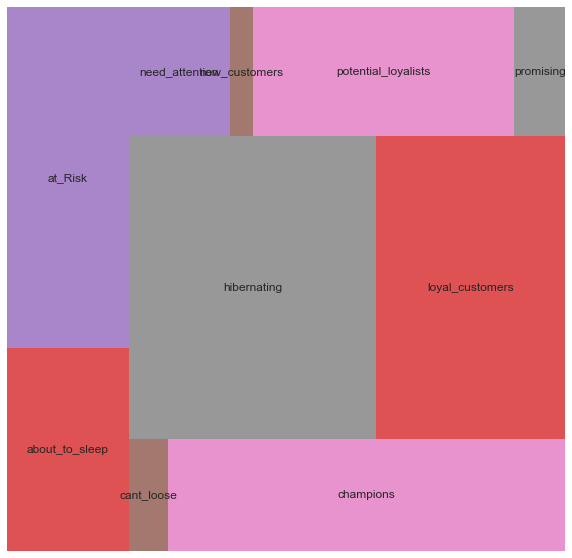

In [67]:
fig, ax = plt.subplots(1, figsize = (10,10))

squarify.plot(sizes=df_treemap['RFM_SCORE'], 
              label=df_treemap['segment'], 
              alpha=.8,
              color=['tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray']
             )
plt.axis('off')
plt.show()
#plt.savefig('treemap.png')

#### K-Means Clustering

In [68]:
rfm_df = rfm[["recency", "frequency", "monetary"]]

# scaler
sc = MinMaxScaler((0, 1))
rfm_df = sc.fit_transform(rfm_df)

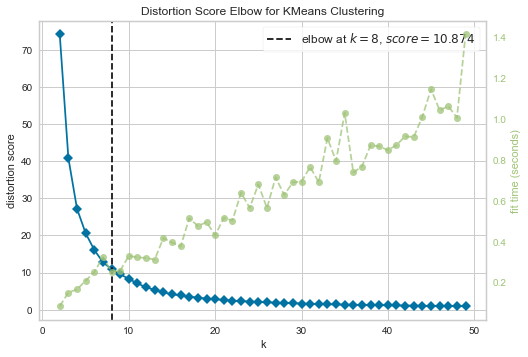

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [69]:
# choose the best cluster number with elbow method

kmeans = KMeans()
elbow = KElbowVisualizer(kmeans, k=(2, 50))
elbow.fit(rfm_df)
elbow.show()

In [70]:
k_means = KMeans(n_clusters = elbow.elbow_value_, random_state=42).fit(rfm_df)
clusters = k_means.labels_


In [71]:
# Get the rfm dataset again and add the cluster numbers...

rfm_df = rfm[["recency", "frequency", "monetary"]]
rfm_df["Cluster"] = clusters
rfm_df["Cluster"] = rfm_df["Cluster"] + 1

rfm_df.head()

,recency,frequency,monetary,Cluster
CustomerID,,,,
12346.0,325,1,77183.60,5
12347.0,2,7,4310.00,1
12348.0,75,4,1797.24,4
12349.0,18,1,1757.55,1
12350.0,310,1,334.40,5


#### RFM vs. Clustering with K-Means

In [72]:
# RFM
rfm.groupby("segment").agg({"monetary": ["count", "mean", "sum"]})

monetary                          
                       count         mean          sum
segment                                               
about_to_sleep           352   469.893437   165402.490
at_Risk                  593  1080.920373   640985.781
cant_loose                63  2790.101429   175776.390
champions                633  6843.160521  4331720.610
hibernating             1071   487.628909   522250.562
loyal_customers          819  2855.791173  2338892.971
need_attention           187   892.505936   166898.610
new_customers             42   385.022381    16170.940
potential_loyalists      484  1036.483099   501657.820
promising                 94   292.050213    27452.720

In [73]:
# Clustering with K-Means
rfm_df.groupby("Cluster").agg({"monetary": ["count", "mean", "sum"]})

monetary                           
           count          mean          sum
Cluster                                    
1           1304   2968.633382  3871097.930
2            349    564.260659   196926.970
3            385    828.206182   318859.380
4            710   1073.757270   762367.662
5            257    675.569339   173621.320
6            949   1273.977704  1209004.841
7             24  87919.188333  2110060.520
8            360    681.306308   245270.271

In [74]:
#RFM is a good choose for the segmentation, Lets check and compare whether clusters with RFM Segments have the same results.
# compare segments and clusters
rfm_vs_kmeans = rfm.merge(rfm_df, how="right", on = "CustomerID")
rfm_vs_kmeans = rfm_vs_kmeans[["segment", "Cluster"]]
rfm_vs_kmeans.head()

,segment,Cluster
CustomerID,,
12346.0,hibernating,5
12347.0,champions,1
12348.0,at_Risk,4
12349.0,promising,1
12350.0,hibernating,5


In [75]:
segments = rfm.groupby("segment").mean()
segments.index

Index(['about_to_sleep', 'at_Risk', 'cant_loose', 'champions', 'hibernating',
       'loyal_customers', 'need_attention', 'new_customers',
       'potential_loyalists', 'promising'],
      dtype='object', name='segment')

In [76]:
for i in segments.index:
    print(i, end="\n\n")
    print(rfm_vs_kmeans[rfm_vs_kmeans["segment"]==i].groupby("Cluster").count())
    print("#####################", end="\n\n")

about_to_sleep

         segment
Cluster         
4            146
6            206
#####################

at_Risk

         segment
Cluster         
2             65
3            188
4            176
5             24
8            140
#####################

cant_loose

         segment
Cluster         
2              3
3             18
4             29
5              2
8             11
#####################

champions

         segment
Cluster         
1            613
7             20
#####################

hibernating

         segment
Cluster         
2            281
3            179
4            171
5            231
8            209
#####################

loyal_customers

         segment
Cluster         
1            304
4            107
6            405
7              3
#####################

need_attention

         segment
Cluster         
4             81
6            106
#####################

new_customers

         segment
Cluster         
1             42
################

 We observe that need_attention and about_to_sleep, they have same clusters, number 4 and 6. In RFM these are neighboor segments